In [6]:
import pandas as pd
import numpy as np
import json
import operator
import itertools 
import matplotlib.pyplot as plt
import re
import subprocess
import seaborn as sns

In [108]:
dataDir="./datasets/"
datasets=[
    "adult",
    "airport",
    "atom",
    "CLASSIFICATION",
    "flights",
    "food",
    "Hospital",
    "inspection",
    "ncvoter",
    "SPStock",
    "tax500k",
]

In [107]:
JARDir="./algorithmJARs/"
algorithms=[
    "Hydra",
    "DCFinder",
    "ADCMiner",
    "FastADC",
]

# Code

## Dataset

In [75]:
class Dataset:
    def __init__(self,file,**args):
        self.columns=pd.read_csv(file,nrows=0).columns
        self.header=[re.match(r'([^\(\)]*)(?:\(| )([^\(\)]*)\)?',col) for col in self.columns]
        self.names=[match[1] for match in self.header]
        typeMap={'String':str,'Integer':float,'Int':float,'Double':float,'int':float,'str':str,'float':float}
        self.types=[typeMap[match[2]] for match in self.header]
        
        self.df=pd.read_csv(file,dtype={col:type for col,type in zip(self.columns,self.types)},**args)
        
    def randRows(self,n):
        ids=np.random.randint(0,len(self.df),n)
        return self.df.iloc[ids]
    def randFields(self,n):
        return pd.DataFrame({col:dfs[col].iloc[list(np.random.randint(0,len(dfs),n))].values for dfs in [self.df] for col in dfs.columns})

    def buildPLIs(self):
        self.PLI= {col:self.df.groupby(by=col).groups for col in self.df}
    def shuffle(self):
        self.df=self.randFields(len(self.df))

## DenialConstraintResult

In [80]:
class Operator:
    def __init__(self,func,expFunc) -> None:
        self.func=func
        self.expFunc=expFunc
    def __call__(self,a,b):
        return self.func(a,b)
    def negate(self):
        return Operator(operator.invert(self.func))
    def expected(self,c1,c2):
        return self.expFunc(c1,c2)
    def __repr__(self) -> str:
        return self.func.__name__
    def __eq__(self, other: object) -> bool:
        if isinstance(other, Operator):
            return self.func==other.func
        return False
    def __hash__(self):
        fields=(self.func)
        hash_value = hash(fields)
        return hash_value

def eqExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    return np.sum(probs**2)-1/len(l)
   

eq=Operator(operator.eq,eqExp)

def neExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    return 1-np.sum(probs**2)
ne=Operator(operator.ne,neExp)

def geExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    cumProbs=np.cumsum(probs)
    return np.sum(probs*(1-cumProbs+probs))-1/len(l)
ge=Operator(operator.ge,geExp)

def leExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    cumProbs=np.cumsum(probs)
    return np.sum(probs*(cumProbs))-1/len(l)
le=Operator(operator.le,leExp)

def gtExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    cumProbs=np.cumsum(probs)
    return np.sum(probs*(1-cumProbs))
gt=Operator(operator.gt,gtExp)

def ltExp(l,r):
    vals,freqs=np.unique(l.values,return_counts=True)
    probs=freqs/len(l)
    cumProbs=np.cumsum(probs)
    return np.sum(probs*(cumProbs-probs))
lt=Operator(operator.lt,ltExp)
operatorMap={
    "EQUAL":eq,
    "UNEQUAL":ne,
    "LESS_EQUAL":le,
    "GREATER_EQUAL":ge,
    "LESS":lt,
    "GREATER":gt
}



class Predicate:
    def __init__(self,l:str,op:Operator,r:str) -> None:
        self.l=l
        self.r=r
        self.op=op
        self.exp=None
    def eval(self,df,t0,t1):
        return self.op(t0[self.l],t1[self.r])
    def expected(self,df):
        if self.exp is None:
            self.exp=self.op.expected(df.df[self.l],None)
        return self.exp
            
    
    def __repr__(self) -> str:
        return '"'+self.l +'" '+self.op.__repr__()+' "'+self.r+'"'
    def __hash__(self):
        fields=(self.l,self.r)
        hash_value = hash(fields)
        return hash_value

    def __eq__(self, other):
        if isinstance(other, Predicate):
            sFields=(self.l,self.op,self.r)
            oFields=(other.l,other.op,other.r)
            return sFields==oFields
        return False


class DenialConstraint:
    def __init__(self,preds) -> None:
        self.preds=preds
    def eval(self,df,t0,t1):
        return sum([pred.eval(df,t0,t1) for pred in self.preds])
    def coverage(self,df,t0s,t1s):
        pos,neg=0,0
        num=self.eval(df,t0s,t1s)
        dclen=len(self.preds)
        pos=(num==dclen).sum()
        neg=(num<dclen).sum()

                
        return neg/(pos+neg)
    def sampleCoverage(self,df,n=None):
        nn=len(df.df)
        if n is None:
            n=nn**2
        t0s = np.random.randint(0,len(df.df),n)
        t1s = np.random.randint(0,len(df.df),n)
        t1s=(t1s+(t1s==t0s)*np.random.randint(1,len(df.df),n))%len(df.df)
        return self.coverage(df,t0s,t1s)
    def expCoverage(self,df):
        return 1-np.prod([pred.expected(df) for pred in self.preds])
    def __repr__(self) -> str:
        return "!["+" & ".join([pred.__repr__() for pred in self.preds])+"]"


class DenialConstraintSet:
    def __init__(self,path,dataset,algorithm) -> None:        
        self.predicates={}
        opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
        def getPred(c1,op,c2):
            if (c1,c2,op) not in self.predicates:
                self.predicates[(c1,c2,op)]=Predicate(c1,opmap[op],c2)
            return self.predicates[(c1,c2,op)]
        
        self.DCs=[]
        
        with open(path) as f:
            for line in f:
                line=line.strip()[2:-1] #strip !(...)
                preds=line.split('^')
                regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'
                if algorithm in ['ADCMiner','FastADC']:
                    regex=r't0\.([^=><]*) (==|<>|>=|<=|>|<) t1\.([^=><]*)'
                preds = [getPred(*re.match(regex,pred).groups()) for pred in preds]
                self.DCs.append(DenialConstraint(preds))


# Result generation

## Discover DCs

In [49]:
for dataset in ["adult"]:
    for algorithm in ["DCFinder","Hydra"]:
        for aprox in ["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm!='Hydra' else ["0.00"]:
            print("RUN: {}_{}_{}".format(algorithm,dataset,aprox))
            command='java -Xmx8g -jar {} {} {} 10000'.format(JARDir+algorithm+'.jar',dataDir+dataset+".csv",aprox)
            result = subprocess.run(command, shell=True)
            print("MOVE: {}_{}_{}".format(algorithm,dataset,aprox))
            command='mv output.txt results/{}_{}_{}'.format(algorithm,dataset,aprox)
            result = subprocess.run(command, shell=True)

RUN: DCFinder_adult_0.00


[main] INFO de.metanome.algorithms.dcfinder.input.Input - Time to build plis: 135
[main] INFO de.metanome.algorithms.dcfinder.DCFinder - Error threshold: 0.0.
[main] INFO de.metanome.algorithms.dcfinder.DCFinder - Discovering DCs with at most 0 violating tuple pairs.
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - First level chunks: 2
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - Available processors: 12
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - Building the Evidence Set...
[main] INFO de.metanome.algorithms.dcfinder.setcover.partial.MinimalCoverSearch - Finding Minimal Covers for the Evidence Set...
[main] INFO de.metanome.algorithms.dcfinder.setcover.partial.MinimalCoverSearch - Building denial constraints...



Lines written to file successfully!
MOVE: DCFinder_adult_0.00
RUN: DCFinder_adult_0.00000001


[main] INFO de.metanome.algorithms.dcfinder.input.Input - Time to build plis: 158
[main] INFO de.metanome.algorithms.dcfinder.DCFinder - Error threshold: 1.0E-8.
[main] INFO de.metanome.algorithms.dcfinder.DCFinder - Discovering DCs with at most 1 violating tuple pairs.
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - First level chunks: 2
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - Available processors: 12
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - Building the Evidence Set...
[main] INFO de.metanome.algorithms.dcfinder.setcover.partial.MinimalCoverSearch - Finding Minimal Covers for the Evidence Set...
[main] INFO de.metanome.algorithms.dcfinder.setcover.partial.MinimalCoverSearch - Building denial constraints...



Lines written to file successfully!
MOVE: DCFinder_adult_0.00000001
RUN: DCFinder_adult_0.000001


[main] INFO de.metanome.algorithms.dcfinder.input.Input - Time to build plis: 152
[main] INFO de.metanome.algorithms.dcfinder.DCFinder - Error threshold: 1.0E-6.
[main] INFO de.metanome.algorithms.dcfinder.DCFinder - Discovering DCs with at most 100 violating tuple pairs.
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - First level chunks: 2
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - Available processors: 12
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - Building the Evidence Set...
[main] INFO de.metanome.algorithms.dcfinder.setcover.partial.MinimalCoverSearch - Finding Minimal Covers for the Evidence Set...
[main] INFO de.metanome.algorithms.dcfinder.setcover.partial.MinimalCoverSearch - Building denial constraints...



Lines written to file successfully!
MOVE: DCFinder_adult_0.000001
RUN: DCFinder_adult_0.0001


[main] INFO de.metanome.algorithms.dcfinder.input.Input - Time to build plis: 138
[main] INFO de.metanome.algorithms.dcfinder.DCFinder - Error threshold: 1.0E-4.
[main] INFO de.metanome.algorithms.dcfinder.DCFinder - Discovering DCs with at most 9999 violating tuple pairs.
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - First level chunks: 2
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - Available processors: 12
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - Building the Evidence Set...
[main] INFO de.metanome.algorithms.dcfinder.setcover.partial.MinimalCoverSearch - Finding Minimal Covers for the Evidence Set...
[main] INFO de.metanome.algorithms.dcfinder.setcover.partial.MinimalCoverSearch - Building denial constraints...



Lines written to file successfully!
MOVE: DCFinder_adult_0.0001
RUN: DCFinder_adult_0.01


[main] INFO de.metanome.algorithms.dcfinder.input.Input - Time to build plis: 137
[main] INFO de.metanome.algorithms.dcfinder.DCFinder - Error threshold: 0.01.
[main] INFO de.metanome.algorithms.dcfinder.DCFinder - Discovering DCs with at most 999900 violating tuple pairs.
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - First level chunks: 2
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - Available processors: 12
[main] INFO de.metanome.algorithms.dcfinder.evidenceset.builders.SplitReconstructEvidenceSetBuilder - Building the Evidence Set...
[main] INFO de.metanome.algorithms.dcfinder.setcover.partial.MinimalCoverSearch - Finding Minimal Covers for the Evidence Set...
[main] INFO de.metanome.algorithms.dcfinder.setcover.partial.MinimalCoverSearch - Building denial constraints...



Lines written to file successfully!
MOVE: DCFinder_adult_0.01
RUN: Hydra_adult_0.00
12:47:48.334 [main] INFO  d.h.n.dc.algorithms.hybrid.Hydra - Building approximate evidence set...
12:47:48.563 [main] INFO  d.h.n.dc.algorithms.hybrid.Hydra - Estimation size systematic sampling:2418
12:47:48.580 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column age(Integer)
12:47:48.698 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column workclass(String)
12:47:48.743 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column fnlwgt(Integer)
12:47:48.818 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column education(String)
12:47:48.848 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column Marital-status(String)
12:47:48.869 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling column occupation(String)
12:47:48.889 [main] INFO  d.h.n.d.e.b.s.ColumnAwareEvidenceSetBuilder - Sampling

## Compute support on random samples

In [64]:
#FROM: https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_clustered_stacked(dfall, axe,title,aproxs,sups,labels=None,  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for ii,i in enumerate(range(0, n_df * n_col, n_col)): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H if  sups[j]<=float(aproxs[ii]) else "") #edited part     
                rect.set_width(0.9 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe

In [ ]:
# create fake dataframes
df1 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"],
                   columns=["I", "J", "K", "L", "M"])
df2 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"],
                   columns=["I", "J", "K", "L", "M"])
df3 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"], 
                   columns=["I", "J", "K", "L", "M"])

# Then, just call :
plot_clustered_stacked([df1, df2, df3],["df1", "df2", "df3"])
    

In [76]:
#load datasets
dss={}
for dataset in datasets:
    print(dataset)
    dss[dataset]=Dataset(dataDir+dataset+".csv",nrows=10000,encoding='unicode_escape')
    dss[dataset].buildPLIs()

adult
airport
atom
CLASSIFICATION
flights
food
Hospital
inspection
ncvoter
SPStock
tax500k


In [81]:
results={}
for algorithm in algorithms[:1]:
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm!='Hydra' else ["0.00"]
    for aprox in aproxs:
        for dataset in ["atom"]:
            print("{}_{}_{}".format(algorithm,dataset,aprox))
            
            dcs=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,algorithm)
            n=10000
            
            t0s=dss[dataset].randFields(n)
            t1s=dss[dataset].randFields(n)
            res=[]
            for dc in dcs.DCs:
                sup=dc.coverage(dcs,t0s,t1s)
                res.append(sup)
            results[(algorithm,dataset,aprox)]=res


Hydra_atom_0.00


KeyboardInterrupt: 

In [110]:
import json
with open("results/DCSups.json") as f:
    results=json.load(f)

In [111]:
algDf={}
for algorithm in algorithms:
    dfs=[]
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm!='Hydra' else ["0.00"]
    sups=np.array([0,1e-4,1e-2,0.1,0.2,0.3])
    for aprox in aproxs:
        df={}
        for dataset in datasets:
            res=results["_".join([algorithm,dataset,aprox])]
            

            counts=np.zeros_like(sups)
            for sup in res:
                sup=sup/0.9999
                counts+=1-sup<=sups
            counts[1:]=counts[1:]-counts[:-1]
            
            df[dataset]=counts/counts.sum()
        dfs.append(pd.DataFrame(df,index=[sups]).transpose())
    algDf[algorithm]=dfs

array([<AxesSubplot:title={'center':'Hydra'}>,
       <AxesSubplot:title={'center':'DCFinder'}>,
       <AxesSubplot:title={'center':'ADCMiner'}>,
       <AxesSubplot:title={'center':'FastADC'}>], dtype=object)

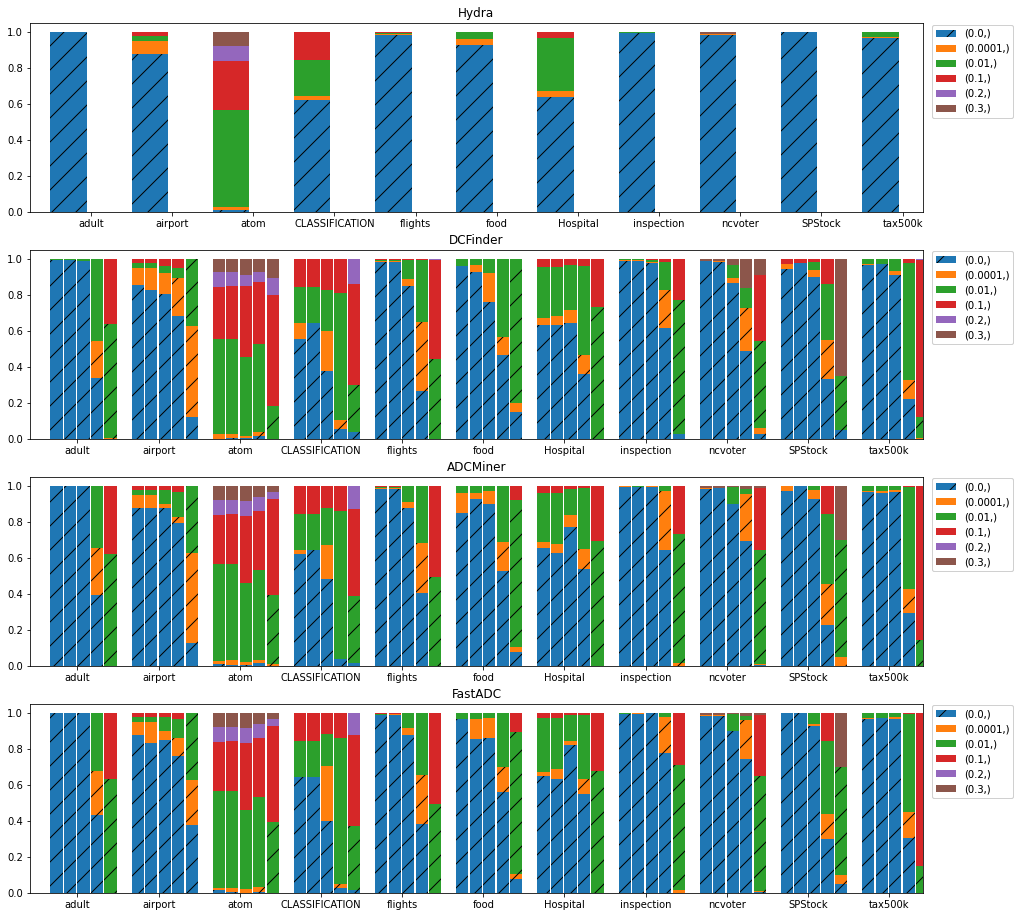

In [113]:
fig,ax=plt.subplots(4,1)
for i,algorithm in enumerate(algorithms):
    plot_clustered_stacked(algDf[algorithm],ax[i],algorithms[i],aproxs,sups,figsize=(16,16))
ax


In [19]:
float("0.00")

0.0

In [78]:

for dataset in datasets:
    print(dataset)
    print(dss[dataset].df.nunique())

adult
age(Integer)                71
workclass(String)            9
fnlwgt(Integer)           8507
education(String)           16
Marital-status(String)       7
occupation(String)          15
relationship(String)         6
race(String)                 5
sex(String)                  2
Native-country(String)      41
class(String)                2
dtype: int64
airport
ident(String)           10000
type(String)                6
name(String)             9575
elevation_ft(String)     2312
continent(String)           1
iso_country(String)         4
iso_region(String)         54
municipality(String)     5220
gps_code(String)         9359
local_code(String)       9403
coordinates(String)      9999
dtype: int64
atom
COL2(Integer)     120
COL4(String)        6
COL5(Integer)     301
COL6(String)      113
COL7(Integer)      14
COL8(Integer)     153
COL9(String)       22
COL10(Integer)    145
COL11(String)       5
COL12(Integer)    138
COL14(Integer)    122
COL21(String)     114
COL22(String)      2

In [105]:
pred=dcs.DCs[0].preds[0]
dcs.DCs[0].expCoverage(dss['atom'])

0.8144367372782474

In [95]:
dss['atom'].df['COL10(Integer)'].value_counts()

23700.0    760
24213.0    600
15279.0    600
23699.0    440
24217.0    440
          ... 
15235.0      1
21647.0      1
17100.0      1
10676.0      1
21596.0      1
Name: COL10(Integer), Length: 145, dtype: int64

In [45]:
df=df.fillna("NaN")

In [46]:
df.to_csv("tax500k.csv",index=False)